# BLOQUE 3: Modelos Avanzados de Series Temporales con ML e IA

## 1. Transformación de series temporales para Machine Learning

Las series temporales tienen una estructura única: los datos dependen del tiempo y del orden. Para usar modelos de machine learning clásicos (que no son secuenciales por sí mismos), debemos transformar la serie en un formato supervisado.

Esto incluye:
- **Crear características basadas en valores anteriores** (lags), para que el modelo pueda aprender dependencias temporales.
- **Extraer variables temporales** como el mes, el trimestre o el año para capturar estacionalidades o efectos de calendario.
- **Normalizar los datos** para que los modelos converjan mejor.

En este ejemplo, simularemos una serie con tendencia y estacionalidad para trabajar después.



C:\Users\USUARIO\AppData\Local\Temp\ipykernel_28952\4142828350.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time = pd.date_range(start='2010-01-01', periods=120, freq='M')


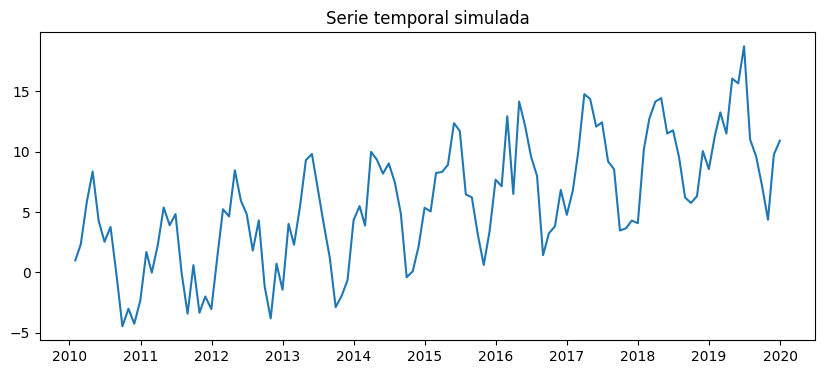

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
time = pd.date_range(start='2010-01-01', periods=120, freq='M')
series = 0.1*np.arange(120) + 5*np.sin(np.arange(120)*2*np.pi/12) + np.random.normal(0, 2, 120)
df = pd.DataFrame({'date': time, 'value': series})

plt.figure(figsize=(10,4))
plt.plot(df['date'], df['value'])
plt.title('Serie temporal simulada')
plt.show()


---

### Creación de características con retrasos y variables temporales

Creamos columnas que contengan los valores de la serie en meses anteriores (lags), y también extraemos información del calendario que pueda ser útil para el modelo.


In [8]:
def create_features(df):
    df = df.copy()
    for lag in range(1, 13):
        df[f'lag_{lag}'] = df['value'].shift(lag)
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df = df.dropna()
    return df

df_feat = create_features(df)
df_feat.head()


,date,value,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,month,quarter,year
12,2011-01-31,1.683925,-2.331460,-4.256962,-3.014880,-4.469076,-0.265131,3.758426,2.531726,4.261820,8.346060,5.825504,2.323471,0.993428,1,1,2011
13,2011-02-28,-0.026560,1.683925,-2.331460,-4.256962,-3.014880,-4.469076,-0.265131,3.758426,2.531726,4.261820,8.346060,5.825504,2.323471,2,1,2011
14,2011-03-31,2.280291,-0.026560,1.683925,-2.331460,-4.256962,-3.014880,-4.469076,-0.265131,3.758426,2.531726,4.261820,8.346060,5.825504,3,1,2011
15,2011-04-30,5.375425,2.280291,-0.026560,1.683925,-2.331460,-4.256962,-3.014880,-4.469076,-0.265131,3.758426,2.531726,4.261820,8.346060,4,2,2011
16,2011-05-31,3.904465,5.375425,2.280291,-0.026560,1.683925,-2.331460,-4.256962,-3.014880,-4.469076,-0.265131,3.758426,2.531726,4.261820,5,2,2011


---

## 2. Implementación de Prophet

Prophet es una librería desarrollada por Facebook (ahora Meta) que facilita la modelización y predicción de series temporales con componentes automáticos de tendencia, estacionalidad y eventos especiales.

**Ventajas de Prophet:**
- Fácil de usar con pocos parámetros.
- Maneja datos faltantes y outliers.
- Proporciona intervalos de confianza en las predicciones.

Aquí entrenamos un modelo básico con estacionalidad anual y predecimos 12 meses hacia el futuro.


In [ ]:
from prophet import Prophet

df_prophet = df.rename(columns={'date':'ds', 'value':'y'})

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title('Predicción con Prophet')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()


---

## 3. Modelos tradicionales de Machine Learning

Aunque Prophet es poderoso, podemos usar modelos clásicos como Random Forest o XGBoost para predecir series temporales, si preparamos adecuadamente las características.

Estos modelos:
- Capturan relaciones no lineales complejas.
- No modelan explícitamente la secuencia, por lo que dependen del feature engineering.

Preparamos los datos con las características creadas y dividimos en conjunto de entrenamiento y prueba para evaluar.


RMSE Random Forest: 2.575
RMSE XGBoost: 2.682


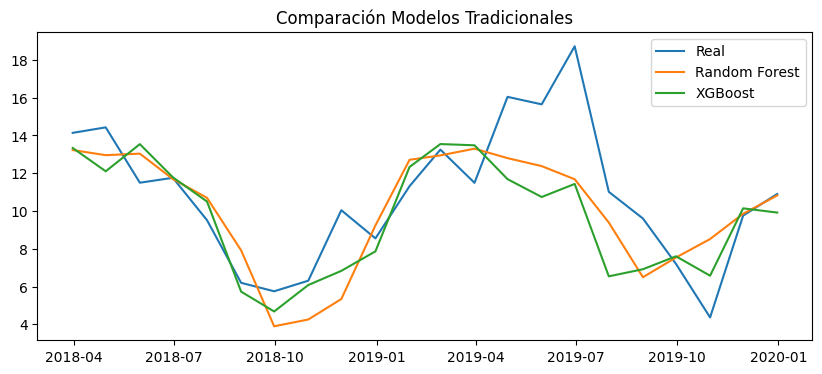

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

X = df_feat.drop(columns=['date', 'value'])
y = df_feat['value']

split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"RMSE Random Forest: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.3f}")

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(f"RMSE XGBoost: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.3f}")

plt.figure(figsize=(10,4))
plt.plot(df_feat['date'].iloc[split_idx:], y_test, label='Real')
plt.plot(df_feat['date'].iloc[split_idx:], y_pred_rf, label='Random Forest')
plt.plot(df_feat['date'].iloc[split_idx:], y_pred_xgb, label='XGBoost')
plt.legend()
plt.title('Comparación Modelos Tradicionales')
plt.show()


---

## 4. Redes Neuronales LSTM con Keras/TensorFlow

Las LSTM son redes recurrentes capaces de capturar dependencias a largo plazo en secuencias, muy útiles para series temporales complejas.

Pasos:
- Normalizamos los datos.
- Creamos secuencias de longitud fija (e.g., 12 meses).
- Construimos un modelo LSTM con dos capas y una capa densa final.
- Entrenamos y visualizamos las predicciones.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(df[['value']])

def create_sequences(data, seq_len=12):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 12
X_lstm, y_lstm = create_sequences(values_scaled, seq_len)

split = int(len(X_lstm)*0.8)
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_len, 1)),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=30, batch_size=16, verbose=1)

y_pred_lstm = model_lstm.predict(X_test_lstm)
y_test_orig = scaler.inverse_transform(y_test_lstm)
y_pred_orig = scaler.inverse_transform(y_pred_lstm)

plt.figure(figsize=(10,4))
plt.plot(range(len(y_test_orig)), y_test_orig, label='Real')
plt.plot(range(len(y_pred_orig)), y_pred_orig, label='Predicción LSTM')
plt.title('Predicción con LSTM')
plt.legend()
plt.show()


---

## 5. Ensamble de modelos

Combinar predicciones de varios modelos suele mejorar la precisión y robustez final, porque cada modelo aporta sus fortalezas.

Aquí hacemos un promedio simple entre Random Forest y LSTM (tras ajustar escalas y tamaños).


In [ ]:
y_pred_rf_cut = y_pred_rf[:len(y_pred_orig)]
ensemble_pred = (y_pred_rf_cut + y_pred_orig.flatten()) / 2

plt.figure(figsize=(10,4))
plt.plot(df_feat['date'].iloc[split_idx:split_idx+len(ensemble_pred)], y_test.iloc[:len(ensemble_pred)], label='Real')
plt.plot(df_feat['date'].iloc[split_idx:split_idx+len(ensemble_pred)], y_pred_rf_cut, label='Random Forest')
plt.plot(df_feat['date'].iloc[split_idx:split_idx+len(ensemble_pred)], y_pred_orig, label='LSTM')
plt.plot(df_feat['date'].iloc[split_idx:split_idx+len(ensemble_pred)], ensemble_pred, label='Ensamble', linestyle='--', color='black')
plt.legend()
plt.title('Ensamble: Promedio RF + LSTM')
plt.show()


---

# Resumen final

Hemos recorrido:

- Cómo transformar series temporales para ML clásico  
- Uso de Prophet para predicciones robustas y fáciles  
- Aplicación de Random Forest y XGBoost con feature engineering  
- Redes LSTM para modelar dependencias largas y no lineales  
- Mejora con ensambles

La elección del modelo depende de la naturaleza del problema y datos, y siempre es bueno probar varios enfoques.


#### Recursos Adicionales 📚

- Prophet: https://facebook.github.io/prophet/
- TensorFlow Time Series: https://www.tensorflow.org/tutorials/structured_data/time_series
- Hands-On Time Series Analysis with Python (Apress, 2020)
- Kaggle Time Series Course: https://www.kaggle.com/learn/time-series